# Домашнее задание 1

In [1]:
import networkx as nx

## Часть 1: анализ графа

Откройте с помощью `networkx.read_gml` файл `netscience.gml` из задания на Gephi, при этом не указывайте при импорте “label=None”, чтобы нормально загрузились имена учёных — метки вершин.

In [2]:
# ваш код тут
science_G = nx.read_gml("netscience.gml")

Средствами `networkx` выведите (сделайте `print` количество вершин и рёбер графа.

In [3]:
# ваш код тут
print(len(science_G.nodes), len(science_G.edges))

1589 2742


Средствами `networkx` найдите количество вершин в самой большой компоненте связности графа.

In [4]:
# ваш код тут
conn_comp = list(nx.connected_components(science_G))
conn_comp_size = [len(comp) for comp in conn_comp]
print(max(conn_comp_size))

379


Сколько изолированных вершин в графе?

In [5]:
# ваш код тут
len(list(filter(lambda x: len(x) == 1, conn_comp)))

128

Нарисуйте с помощью `networkx.draw_spring` единственную 21-вершинную компоненту связности графа. Может пригодиться метод `subgraph`, возвращающий подграф заданного графа, порождённый заданным множеством вершин.

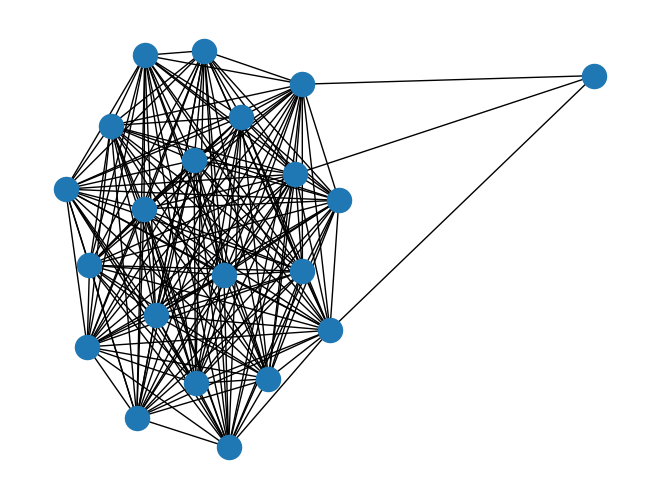

In [6]:
# ваш код тут
nx.draw_spring(nx.subgraph(science_G, conn_comp[conn_comp_size.index(21)]))

Найдите с помощью networkx (см. [документацию](https://networkx.github.io/documentation/stable/reference/algorithms/clique.html)) размер максимальной клики в упомянутой выше 21-вершинной компоненте связности.

In [7]:
# ваш код тут
cliques = list(nx.find_cliques(science_G))
cliques_size = [len(cl) for cl in cliques]
print(max(cliques_size))

20


## Часть 2: построение графа

Создайте с нуля (только с помощью `add_nodes_from` и `add_edges_from`) граф типа `lollipop` (но без использования встроенной в `networkx` функции `lollipop_graph`) — клику на 10 вершинах, к которой приделана цепь на 6 вершинах. Нарисуйте этот граф наиболее подходящим по Вашему мнению алгоритмом, предоставляемым `networkx` — поэкспериментируйте.


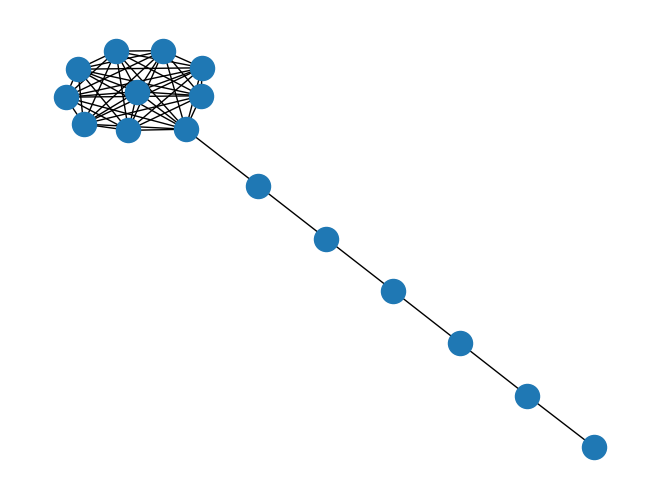

In [8]:
# ваш код тут
lollipop_G = nx.empty_graph()
lollipop_G.add_nodes_from(range(16))
clique_edges = [(n_i, n_j) for n_i in range(10) for n_j in range(n_i + 1, 10)]
chain_edges = [(n_i, n_i + 1) for n_i in range(9, 15)]
lollipop_G.add_edges_from(clique_edges + chain_edges)

nx.draw_kamada_kawai(lollipop_G)

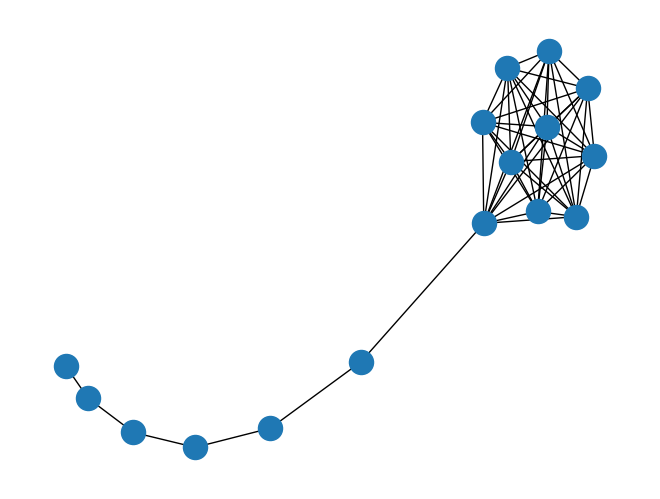

In [9]:
nx.draw_forceatlas2(lollipop_G)

Создайте граф, который получается из цикла на 10 вершинах добавлением одного ребра между какой-нибудь парой диаметрально противоположных вершин. Нарисуйте этот граф наиболее подходящим по Вашему мнению алгоритмом, предоставляемым networkx — поэкспериментируйте.

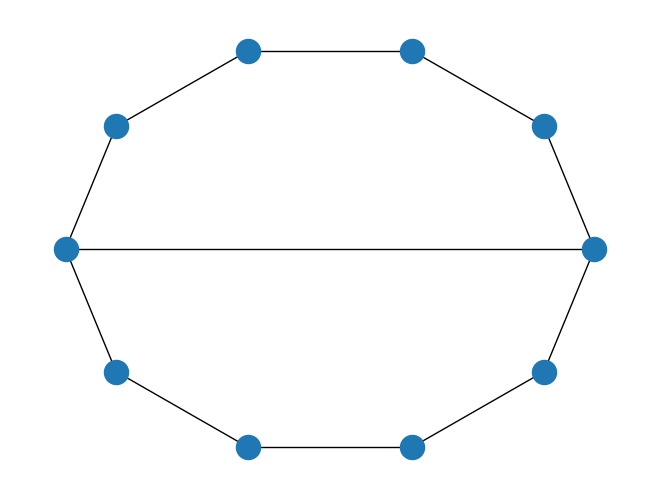

In [10]:
# ваш код тут
sym_G = nx.cycle_graph(10)
sym_G.add_edge(0, 5)
nx.draw_circular(sym_G)

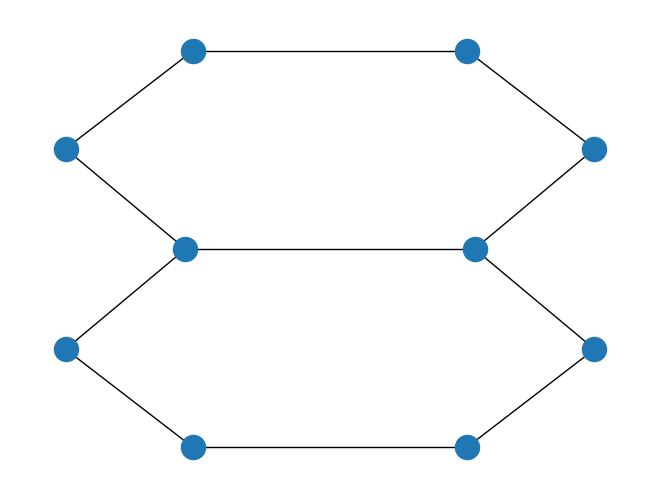

In [11]:
nx.draw_kamada_kawai(sym_G)

## Часть 3: жадный алгоритм раскраски

Найдите для заданного `networkx`-графа $G$ раскраску не более, чем в $\Delta(G)$ цветов с помощью рассказанного на лекции «жадного» алгоритма. Технически раскраска — это словарь, в котором для каждой вершины указан её номер цвета от $1$ до $\Delta(G)$. Рассмотрите какие-нибудь эвристики выбора порядка вершин, в котором они раскрашиваются алгоритмом. Сравните результаты работы алгоритма при данных эвристиках. 

In [12]:
def greedy_coloring(G: nx.Graph, heuristic: str = ""):
    _, max_deg = max(G.degree, key=lambda x: x[1])
    palette = set(range(1, max_deg + 2))
    colors = {}
    if heuristic == "":
        order = list(G.nodes())
    elif heuristic == "betweenness":
        order = [
            it[0]
            for it in sorted(
                nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True
            )
        ]
    elif heuristic == "closeness":
        order = [
            it[0]
            for it in sorted(
                nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse=True
            )
        ]
    else:  # "dynamic" основано на DSatur: https://dl.acm.org/doi/pdf/10.1145/359094.359101
        num_colored_neigh = {n: 0 for n in G.nodes()}
        uncolored = list(G.nodes())
        while uncolored:
            node = max(uncolored, key=lambda n: num_colored_neigh[n])
            neighbor_colors = {colors[n] for n in G.neighbors(node) if n in colors}
            for c in palette:
                if c not in neighbor_colors:
                    colors[node] = c
                    break

            uncolored.remove(node)
            for n in G.neighbors(node):
                if n in uncolored:
                    num_colored_neigh[n] = len(
                        {colors[m] for m in G.neighbors(n) if m in colors}
                    )
        return colors

    for node in order:
        neighbor_colors = {colors[n] for n in G.neighbors(node) if n in colors}
        colors[node] = min(palette - neighbor_colors)
    return colors

In [13]:
# Простой тест алгоритма раскраски (запустите перед отправкой):
G = nx.random_regular_graph(7, 500, 2020)


def check_coloring(coloring):
    assert (
        max(coloring.values()) <= 7
        and min(coloring.values()) >= 1
        and all(coloring[u] != coloring[v] for u, v in G.edges())
    )


for col_type in ["", "betweenness", "closeness", "dynamic"]:
    coloring = greedy_coloring(G, heuristic=col_type)
    check_coloring(coloring)
    print(
        f"Coloring type: {col_type if col_type != '' else 'none'} | max col: {max(coloring.values())}"
    )

Coloring type: none | max col: 6
Coloring type: betweenness | max col: 6
Coloring type: closeness | max col: 7
Coloring type: dynamic | max col: 5
